In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [3]:
train_dir=r'H:\WorkOut\Research\Tomato Disease\tomato_dataset\train'
valid_dir=r'H:\WorkOut\Research\Tomato Disease\tomato_dataset\val'
for d in [train_dir, valid_dir]:
    filepaths = []
    labels=[] 
    classlist=sorted(os.listdir(d))
    for klass in classlist:
        label=klass.split('__')[1]
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)            
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    if d == train_dir:
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        valid_df=pd.concat([Fseries, Lseries], axis=1)
train_df, test_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])   
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  9000   test_df length:  1000   valid_df length:  1000
The number of classes in the dataset is:  10
            CLASS               IMAGE COUNT 
       _Bacterial_spot              900     
        _Early_blight               900     
         _Late_blight               900     
          _Leaf_Mold                900     
     _Septoria_leaf_spot            900     
_Spider_mites Two-spotted_spider_mite      900     
         _Target_Spot               900     
_Tomato_Yellow_Leaf_Curl_Virus      900     
     _Tomato_mosaic_virus           900     
           _healthy                 900     
_Bacterial_spot  has the most images=  900   _Bacterial_spot  has the least images=  900
average height=  256  average width=  256 aspect ratio=  1.0


In [4]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

#trim
max_samples=200
min_samples=200
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  200


In [5]:
working_dir=r'./'
img_size=(256,256)
batch_size=30
trgen=ImageDataGenerator(horizontal_flip=True,
                         rotation_range=20, 
                         width_shift_range=.2,
                         height_shift_range=.2,
                         zoom_range=.2 )

t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='')

train_gen=trgen.flow_from_dataframe(train_df,
                                    x_col='filepaths',
                                    y_col='labels',
                                    target_size=img_size,
                                    class_mode='categorical',
                                    color_mode='rgb',
                                    shuffle=True,
                                    batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='')

valid_gen=t_and_v_gen.flow_from_dataframe(valid_df,
                                          x_col='filepaths',
                                          y_col='labels',
                                          target_size=img_size,
                                          class_mode='categorical',
                                          color_mode='rgb',
                                          shuffle=False,
                                          batch_size=batch_size)

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='')

test_gen=t_and_v_gen.flow_from_dataframe(test_df,
                                         x_col='filepaths',
                                         y_col='labels',
                                         target_size=img_size,
                                         class_mode='categorical',
                                         color_mode='rgb',
                                         shuffle=False,
                                         batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 2000 validated image filenames belonging to 10 classes.          for train generator 
Found 1000 validated image filenames belonging to 10 classes.          for valid generator 
Found 1000 validated image filenames belonging to 10 classes.          for test generator 
test batch size:  50   test steps:  20  number of classes :  10


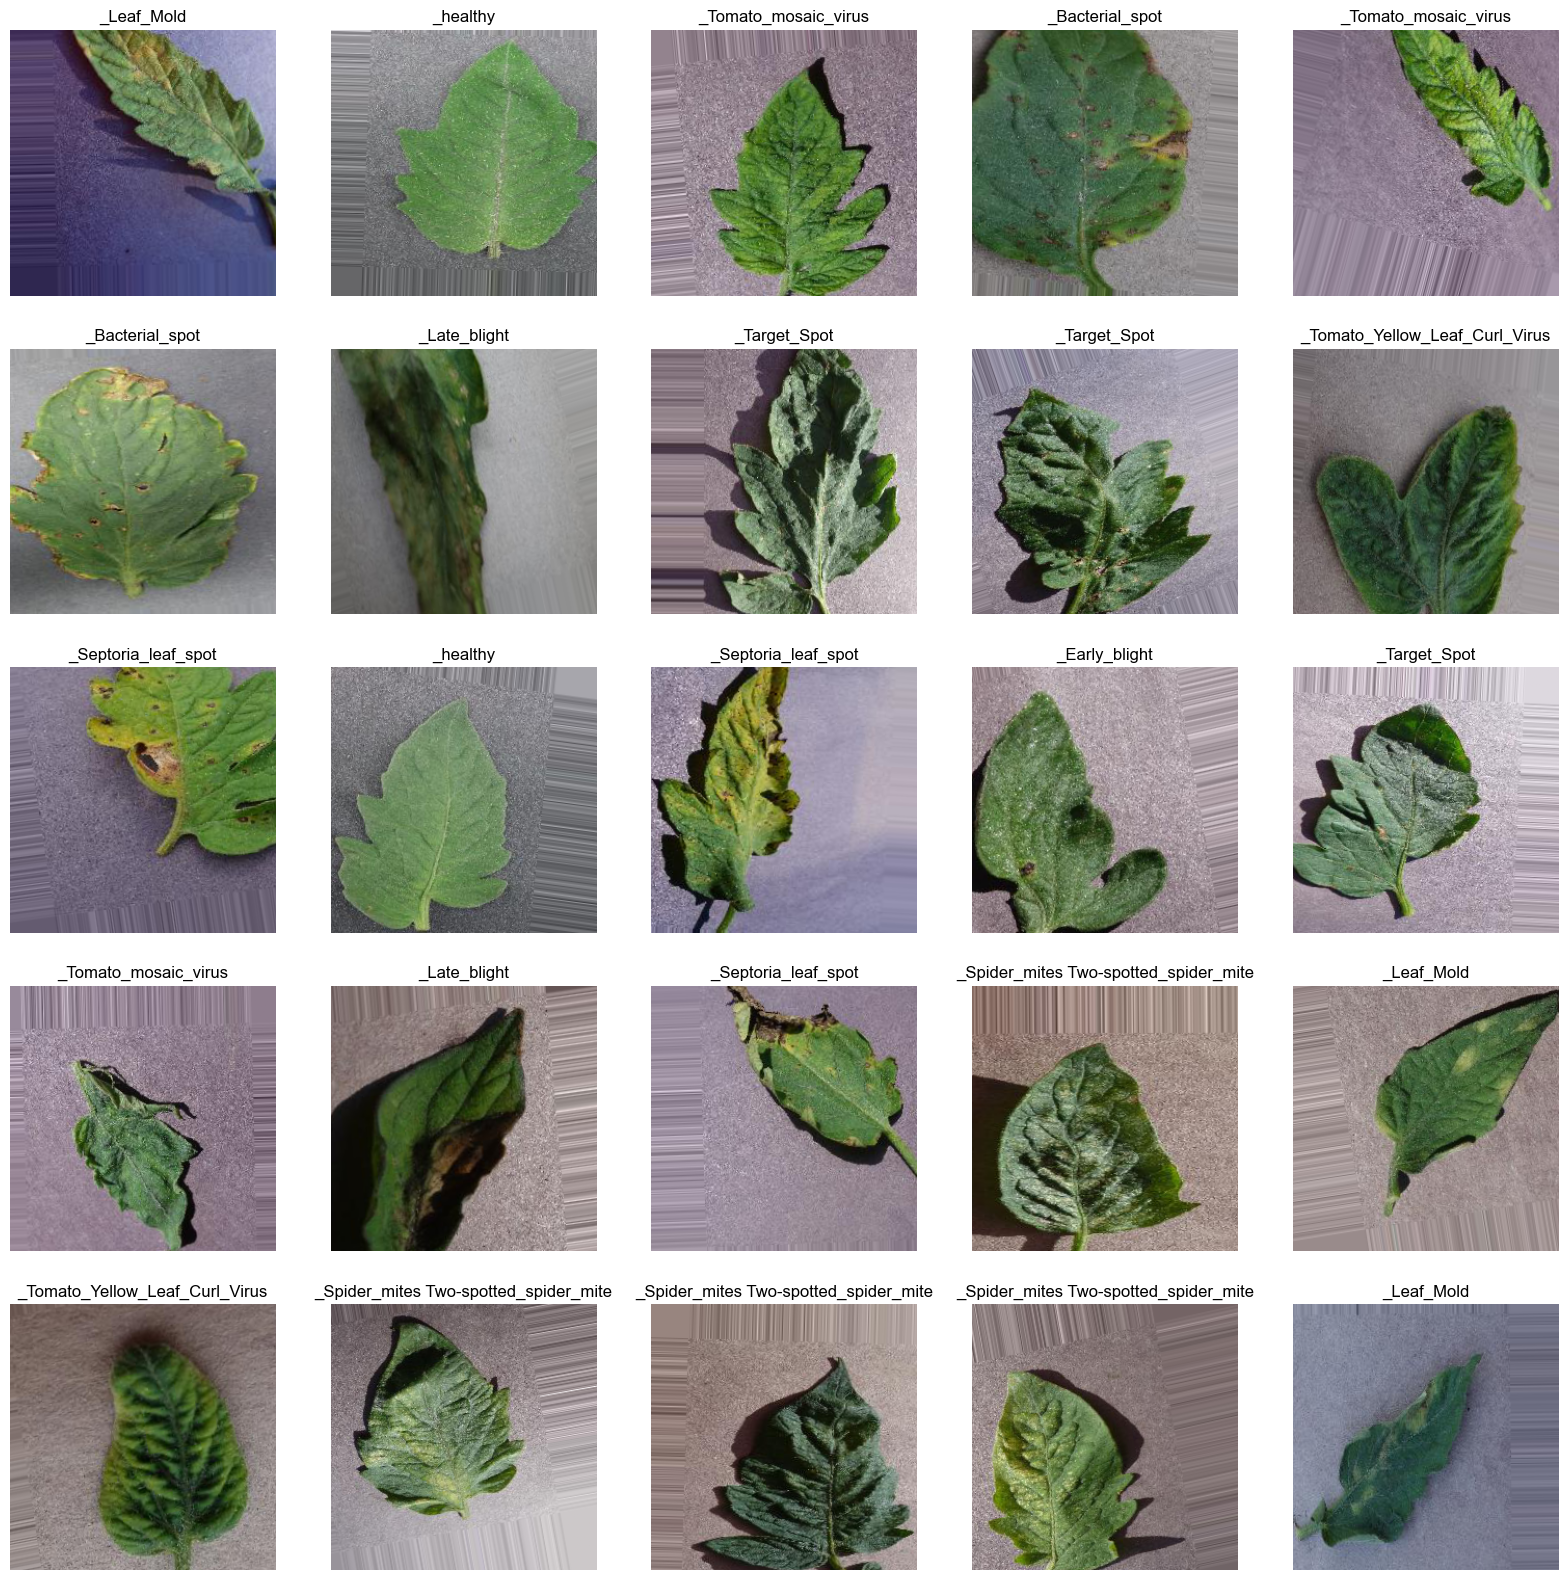

In [6]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='black', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [9]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)

lr=.001
model.summary()
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 128, 128, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 128, 128, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 128, 128, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_d

 block2c_expand_activation (Act  (None, 64, 64, 192)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 64, 64, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 64, 64, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 64, 64, 192)  0          ['block2c_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 32, 32, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_s

 block4a_activation (Activation  (None, 16, 16, 288)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_s

 block4c_se_expand (Conv2D)     (None, 1, 1, 576)    14400       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 16, 16, 576)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 16, 16, 96)   55296       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 16, 16, 96)  384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_d

 block4e_project_conv (Conv2D)  (None, 16, 16, 96)   55296       ['block4e_se_excite[0][0]']      
                                                                                                  
 block4e_project_bn (BatchNorma  (None, 16, 16, 96)  384         ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 16, 16, 96)   0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 16, 16, 96)   0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_e

 block5c_expand_conv (Conv2D)   (None, 16, 16, 816)  110976      ['block5b_add[0][0]']            
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 16, 16, 816)  3264       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 16, 16, 816)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 16, 16, 816)  20400      ['block5c_expand_activation[0][0]
 D)                                                              ']                               
          

 block5e_expand_activation (Act  (None, 16, 16, 816)  0          ['block5e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, 16, 16, 816)  20400      ['block5e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 16, 16, 816)  3264       ['block5e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 16, 16, 816)  0          ['block5e_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 8, 8, 1392)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1392)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_s

 block6d_se_squeeze (GlobalAver  (None, 1392)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 8, 8, 1392)   0           ['block6d_activation[0][0]',     
          

 block6f_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 8, 8, 1392)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 8, 8, 232)    322944      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 8, 8, 232)   928         ['block6f_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block7b_drop (Dropout)         (None, 8, 8, 384)    0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_add (Add)              (None, 8, 8, 384)    0           ['block7b_drop[0][0]',           
                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 top_conv (Conv2D)              (None, 8, 8, 1536)   589824      ['block7b_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 8, 8, 1536)   6144        ['top_conv[0][0]']               
          

In [10]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch):
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True
        
    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: 
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False 
        if self.epochs == 1:
            self.ask=False
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter S to stop training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() 
        
    def on_train_end(self, logs=None):    
        tr_duration=time.time() - self.start_time           
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) 
        
    def on_epoch_end(self, epoch, logs=None):  
        if self.ask: 
            if epoch + 1 ==self.ask_epoch: 
                print('\n Enter S to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'S' or ans =='s' or ans == '0':
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True 
                else: 
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [11]:
epochs=30
ask_epoch=5
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

In [12]:
history=model.fit(x=train_gen,
                  epochs=epochs,
                  verbose=1,
                  callbacks=callbacks,
                  validation_data=valid_gen,
                  validation_steps=None,
                  shuffle=False,
                  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter S to stop training or enter an integer for how many more epochs to run then be asked again
Epoch 1/30
67/67 [==============================] - 1142s 16s/step - loss: 8.5263 - accuracy: 0.6470 - val_loss: 8.5146 - val_accuracy: 0.6160 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - 1110s 17s/step - loss: 6.6949 - accuracy: 0.8810 - val_loss: 6.3881 - val_accuracy: 0.8530 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - 1073s 16s/step - loss: 5.6086 - accuracy: 0.9275 - val_loss: 5.2792 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 4/30
67/67 [==============================] - 1089s 16s/step - loss: 4.7187 - accuracy: 0.9550 - val_loss: 4.4376 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 5/30
67/67 [==============================] - ETA: 0s - loss: 4.0014 - accuracy: 0.9675 
 Enter S to end training or  an integer for the number of additional epochs to run then ask again
10
you entered  10  Tr

In [ ]:
def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) 
    tests=len(preds)
    
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  
            if pred_index != true_index:                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4)
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

In [ ]:

def plot_predictions(model, generator, classNames, num_images=15):
    plt.figure(figsize=(15, 15))
    gs = plt.GridSpec(5, 3, height_ratios=[1, 1, 1.2, 1.2, 1.2], wspace=0.1, hspace=0.4)
    i = 0
    while i < num_images:
        images, labels = next(generator)
        images = np.array(images)
        predictions = model.predict(images)
        for j in range(images.shape[0]):
            ax = plt.subplot(gs[i])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(False)
            ax.imshow(images[j] / 255.0)
            predicted_class = classNames[np.argmax(predictions[j])]
            confidence = round(100 * (np.max(predictions[j])), 2)
            actual_class = classNames[np.argmax(labels[j])]
            ax.set_title(f"Actual: {actual_class}, \nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=10)
            i += 1
            if i == num_images:
                break
        if i == num_images:
            break
    plt.show()



In [ ]:
plot_predictions(model, test_gen, classlist, num_images=15)
